In [1]:
import torch
import torch.nn as nn 
import pandas as pd

In [2]:
data = pd.read_csv(r"C:\Users\mmuth\Downloads\new_data.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18439 entries, 0 to 18438
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   No.                18439 non-null  int64  
 1   Time               18439 non-null  float64
 2   Source             18439 non-null  object 
 3   Destination        18439 non-null  object 
 4   Protocol           18439 non-null  object 
 5   Length             18439 non-null  int64  
 6   timestamp          18439 non-null  object 
 7   source port        18254 non-null  float64
 8   destination port   18254 non-null  float64
 9   dest resolve       18439 non-null  object 
 10  dest unresolve     18254 non-null  float64
 11  serverity          16124 non-null  object 
 12  sort port resolve  18254 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 1.8+ MB


In [3]:
import re

# regex for IPv4 or IPv6
ip_regex = r'^(' \
           r'(\d{1,3}\.){3}\d{1,3}' \
           r'|' \
           r'([0-9a-fA-F]{0,4}:){2,7}[0-9a-fA-F]{0,4}' \
           r')$'

# create boolean mask
mask = data['Source'].astype(str).str.match(ip_regex, na=False)

# keep only rows where Source is an IP address
data = data[mask]

# verify
data['Source'].unique()

array(['34.104.35.123', '10.17.102.184', '10.17.25.174', '0.0.0.0',
       '10.17.0.6', '10.17.248.31', '10.17.0.2', '172.64.155.209',
       '10.17.149.35', '10.17.176.228', '10.17.88.183',
       'fe80::3c09:33ff:fe60:32a6', '10.17.110.135', '10.17.203.145',
       '36:c4:1c:7f:fb:6d', '10.17.66.69', 'fe80::4deb:349:87b6:20cb',
       '10.17.245.199', '10.17.127.178', 'c2:91:ac:56:aa:04',
       '10.17.116.10', '10.17.229.183', '10.17.0.1', '00:6f:00:08:1b:25',
       '4e:cb:60:a6:ca:34', '06:d1:71:c3:2e:0d', '10.17.119.61',
       '7e:d7:85:a2:9b:bc', '10.17.120.135', 'fe80::dc83:7cff:fe7c:3e1a',
       '76:47:15:9d:d8:a8', '10.17.57.158'], dtype=object)

In [4]:
remove_values = [
    'fe80::3c09:33ff:fe60:32a6',
    '36:c4:1c:7f:fb:6d',
    'fe80::4deb:349:87b6:20cb',
    'c2:91:ac:56:aa:04',
    '4e:cb:60:a6:ca:34',
    '06:d1:71:c3:2e:0d',
    '7e:d7:85:a2:9b:bc',
    'fe80::dc83:7cff:fe7c:3e1a',
    '76:47:15:9d:d8:a8',
    '00:6f:00:08:1b:25'
]

data = data[~data['Source'].isin(remove_values)]

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18247 entries, 0 to 18438
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   No.                18247 non-null  int64  
 1   Time               18247 non-null  float64
 2   Source             18247 non-null  object 
 3   Destination        18247 non-null  object 
 4   Protocol           18247 non-null  object 
 5   Length             18247 non-null  int64  
 6   timestamp          18247 non-null  object 
 7   source port        18247 non-null  float64
 8   destination port   18247 non-null  float64
 9   dest resolve       18247 non-null  object 
 10  dest unresolve     18247 non-null  float64
 11  serverity          16121 non-null  object 
 12  sort port resolve  18247 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 1.9+ MB


In [5]:
def add_attack(protocol,source_port) : 
    if protocol is None or source_port!=source_port : 
        return 0
    tcp_port ={
        21,22,23,25,139,443,3389,80,4444,1337,8080
    }
    if protocol=='TCP' and source_port in tcp_port : 
        return 1
    udp_port ={
        19,53,123,1900,8080,4444,1337,80
    }
    if protocol =='UDP' and source_port in udp_port :
        return 1
    if protocol =='ICMP' :
        return 1
    if protocol =='ARP' : 
        return 1
    return 0

In [6]:
data['Attack'] = data.apply(
    lambda row: add_attack(
        row['Protocol'],
        row['source port ']
    ),
    axis=1
)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18247 entries, 0 to 18438
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   No.                18247 non-null  int64  
 1   Time               18247 non-null  float64
 2   Source             18247 non-null  object 
 3   Destination        18247 non-null  object 
 4   Protocol           18247 non-null  object 
 5   Length             18247 non-null  int64  
 6   timestamp          18247 non-null  object 
 7   source port        18247 non-null  float64
 8   destination port   18247 non-null  float64
 9   dest resolve       18247 non-null  object 
 10  dest unresolve     18247 non-null  float64
 11  serverity          16121 non-null  object 
 12  sort port resolve  18247 non-null  float64
 13  Attack             18247 non-null  int64  
dtypes: float64(5), int64(3), object(6)
memory usage: 2.1+ MB


In [7]:
data['serverity '] = (
    data
    .groupby(['Protocol', 'source port '])['serverity ']
    .transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else 'Note'))
)

In [8]:
data[['soct1','scot2','scot3','scot4']] = data['Source'].str.split('.',expand=True).astype('int64')
data[['doct1','dcot2','dcot3','dcot4']] = data['Destination'].str.split('.',expand=True).astype('int64')

In [9]:
from sklearn.preprocessing import LabelEncoder

enc = LabelEncoder()

data['enc_protocol'] = enc.fit_transform(data['Protocol'])
data['enc_ser'] = enc.fit_transform(data['serverity '])

In [10]:
from ctgan import CTGAN

ctgan = CTGAN(epochs=100)

data = data.drop(data[['Source','Destination','Protocol','timestamp','dest resolve','serverity ']],axis=1)
ctgan.fit(data)
data = ctgan.sample(10500)
data.info()

e:\anaconda3\Lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10500 entries, 0 to 10499
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   No.                10500 non-null  int64  
 1   Time               10500 non-null  float64
 2   Length             10500 non-null  int64  
 3   source port        10500 non-null  float64
 4   destination port   10500 non-null  float64
 5   dest unresolve     10500 non-null  float64
 6   sort port resolve  10500 non-null  float64
 7   Attack             10500 non-null  int64  
 8   soct1              10500 non-null  int64  
 9   scot2              10500 non-null  int64  
 10  scot3              10500 non-null  int64  
 11  scot4              10500 non-null  int64  
 12  doct1              10500 non-null  int64  
 13  dcot2              10500 non-null  int64  
 14  dcot3              10500 non-null  int64  
 15  dcot4              10500 non-null  int64  
 16  enc_protocol       105

In [11]:
x = data.drop('Attack',axis=1)
y = data['Attack']

In [12]:
x = torch.tensor(x.values,dtype=torch.float32)
y = torch.tensor(y.values,dtype=torch.float32)

In [13]:
x = (x-x.mean())/x.std()
y = (y-y.mean())/y.std()

In [14]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=2)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

torch.Size([7350, 17])
torch.Size([3150, 17])
torch.Size([7350])
torch.Size([3150])


In [15]:
class network(nn.Module) :
    def __init__(self):
        super(network,self).__init__()
        self.layer1 = nn.Linear(17,32)
        self.layer2 = nn.Linear(32,64)
        self.layer3 = nn.Linear(64,32)
        self.layer4 = nn.Linear(32,1)
        self.relu = nn.ReLU()
    def forward(self,x) :
        x = self.layer1(x)
        x = self.relu(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.layer3(x)
        x = self.relu(x)
        x = self.layer4(x)
        return x 

In [16]:
from torch.utils.data import TensorDataset,DataLoader

batch_size=12

train_dataset = TensorDataset(x_train,y_train)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True)
val_dataset = TensorDataset(x_test,y_test)
val_loader = DataLoader(val_dataset,batch_size=batch_size,shuffle=True)

In [23]:
import torch.optim as optim
from tqdm import tqdm 

model = network()
condition = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

train_mse_history = []
val_mse_history  = [] 

train_acc_history = [] 
val_acc_history = []
no_epochs = 50

for epoch in range(no_epochs) : 
    model.train()
    train_loss = 0.0
    correct = 0
    total =0
    for x_batch,y_batch in tqdm(train_loader) :
        optimizer.zero_grad(set_to_none=True)
        
        y_batch = y_batch.float().unsqueeze(1)
        
        prediction = model(x_batch)
        loss = condition(prediction,y_batch)
        
        loss.backward()
        optimizer.step()
        
        train_loss +=loss.item()
        
        pred = (torch.sigmoid(prediction)>0.3).long()
        correct += (pred==y_batch.long()).sum().item()
        total += y_batch.size(0)
    train_loss /=len(train_loader)
    train_acc = correct/total
    train_mse_history.append(train_loss)
    train_acc_history.append(train_acc)
    model.eval()
    val_loss =0 
    correct = 0 
    total = 0
    with torch.no_grad() :
        for x_batch,y_batch in tqdm(val_loader) : 
            y_batch = y_batch.float().unsqueeze(1)
            
            prediction = model(x_batch)
            loss = condition(prediction,y_batch)
            
            val_loss+=loss.item()
            
            pred = (torch.sigmoid(prediction)>0.3).long()
            correct +=(pred==y_batch.long()).sum().item()
            total += y_batch.size(0)
    val_loss /=len(val_loader)
    val_acc = correct/total
    val_mse_history.append(val_loss)
    val_acc_history.append(val_acc)
    print(f"train loss : {train_loss:.4f} | "
          f"val loss : {val_loss:.4f} | "
          f"train acc : {train_acc:.4f} | "
          f"val Acc : {val_acc:.4f}")



100%|██████████| 263/263 [00:00<00:00, 2733.63it/s]


train loss : -8179.6573 | val loss : -48552.8381 | train acc : 0.2039 | val Acc : 0.1206


100%|██████████| 263/263 [00:00<00:00, 2750.73it/s]


train loss : -305823.3750 | val loss : -789303.8420 | train acc : 0.3152 | val Acc : 0.8025


100%|██████████| 263/263 [00:00<00:00, 2153.31it/s]


train loss : -1906636.5277 | val loss : -3484244.2325 | train acc : 0.3887 | val Acc : 0.7889


100%|██████████| 263/263 [00:00<00:00, 2591.48it/s]


train loss : -6190506.6193 | val loss : -9587896.5661 | train acc : 0.4367 | val Acc : 0.1460


100%|██████████| 263/263 [00:00<00:00, 2828.21it/s]


train loss : -14550522.1678 | val loss : -20429990.0479 | train acc : 0.4659 | val Acc : 0.7892


100%|██████████| 263/263 [00:00<00:00, 2658.31it/s]


train loss : -28161536.9699 | val loss : -37477832.1072 | train acc : 0.4765 | val Acc : 0.7778


100%|██████████| 263/263 [00:00<00:00, 2641.27it/s]


train loss : -48744829.1776 | val loss : -61791446.6914 | train acc : 0.5086 | val Acc : 0.1448


100%|██████████| 263/263 [00:00<00:00, 2479.96it/s]


train loss : -77372432.0121 | val loss : -94953693.4818 | train acc : 0.5093 | val Acc : 0.7762


100%|██████████| 263/263 [00:00<00:00, 2715.71it/s]


train loss : -115107238.3786 | val loss : -138086470.6686 | train acc : 0.5212 | val Acc : 0.1419


100%|██████████| 263/263 [00:00<00:00, 2608.31it/s]


train loss : -164083259.7368 | val loss : -193249155.8170 | train acc : 0.5267 | val Acc : 0.7990


100%|██████████| 263/263 [00:00<00:00, 2544.85it/s]


train loss : -224311947.0154 | val loss : -261790610.4414 | train acc : 0.5399 | val Acc : 0.1305


100%|██████████| 263/263 [00:00<00:00, 2369.31it/s]


train loss : -297701879.5457 | val loss : -341069572.9467 | train acc : 0.5401 | val Acc : 0.1416


100%|██████████| 263/263 [00:00<00:00, 2717.33it/s]


train loss : -386497591.8315 | val loss : -437727987.7195 | train acc : 0.5502 | val Acc : 0.8048


100%|██████████| 263/263 [00:00<00:00, 2371.52it/s]


train loss : -491096040.8964 | val loss : -552610610.9870 | train acc : 0.5454 | val Acc : 0.8127


100%|██████████| 263/263 [00:00<00:00, 2599.83it/s]


train loss : -615181001.6616 | val loss : -685326645.3321 | train acc : 0.5448 | val Acc : 0.8095


100%|██████████| 263/263 [00:00<00:00, 2679.29it/s]


train loss : -758707108.8830 | val loss : -842716900.9206 | train acc : 0.5585 | val Acc : 0.1498


100%|██████████| 263/263 [00:00<00:00, 2487.59it/s]


train loss : -923101786.9805 | val loss : -1019002527.9160 | train acc : 0.5484 | val Acc : 0.1489


100%|██████████| 263/263 [00:00<00:00, 2309.07it/s]


train loss : -1114204267.6067 | val loss : -1224284974.8462 | train acc : 0.5577 | val Acc : 0.8130


100%|██████████| 263/263 [00:00<00:00, 2645.46it/s]


train loss : -1333182760.8511 | val loss : -1455521671.0148 | train acc : 0.5607 | val Acc : 0.1495


100%|██████████| 263/263 [00:00<00:00, 2779.36it/s]


train loss : -1573134466.8032 | val loss : -1716566076.1863 | train acc : 0.5525 | val Acc : 0.8254


100%|██████████| 263/263 [00:00<00:00, 2868.52it/s]


train loss : -1845115621.6005 | val loss : -2001179835.1672 | train acc : 0.5566 | val Acc : 0.8146


100%|██████████| 263/263 [00:00<00:00, 2774.92it/s]


train loss : -2147485594.2325 | val loss : -2327837248.3150 | train acc : 0.5612 | val Acc : 0.1467


100%|██████████| 263/263 [00:00<00:00, 2461.41it/s]


train loss : -2487247177.7608 | val loss : -2685666234.5303 | train acc : 0.5554 | val Acc : 0.8168


100%|██████████| 263/263 [00:00<00:00, 2861.18it/s]


train loss : -2859199360.0701 | val loss : -3073233453.3813 | train acc : 0.5582 | val Acc : 0.8149


100%|██████████| 263/263 [00:00<00:00, 3054.69it/s]


train loss : -3272919450.3842 | val loss : -3521325746.4689 | train acc : 0.5634 | val Acc : 0.1422


100%|██████████| 263/263 [00:00<00:00, 2700.09it/s]


train loss : -3724698826.4836 | val loss : -4006447249.9674 | train acc : 0.5593 | val Acc : 0.1502


100%|██████████| 263/263 [00:00<00:00, 2947.53it/s]


train loss : -4227480545.0951 | val loss : -4519360113.1025 | train acc : 0.5605 | val Acc : 0.1483


100%|██████████| 263/263 [00:00<00:00, 2709.12it/s]


train loss : -4772788910.0167 | val loss : -5077610614.6655 | train acc : 0.5603 | val Acc : 0.8133


100%|██████████| 263/263 [00:00<00:00, 2631.20it/s]


train loss : -5367450881.2580 | val loss : -5713559218.7325 | train acc : 0.5646 | val Acc : 0.8098


100%|██████████| 263/263 [00:00<00:00, 2734.99it/s]


train loss : -6000509405.7344 | val loss : -6367122060.1693 | train acc : 0.5624 | val Acc : 0.8146


100%|██████████| 263/263 [00:00<00:00, 2708.23it/s]


train loss : -6701569876.4524 | val loss : -7108402696.6264 | train acc : 0.5615 | val Acc : 0.8143


100%|██████████| 263/263 [00:00<00:00, 2511.40it/s]


train loss : -7454438240.1163 | val loss : -7920256656.5325 | train acc : 0.5634 | val Acc : 0.1483


100%|██████████| 263/263 [00:00<00:00, 2723.31it/s]


train loss : -8257799443.5085 | val loss : -8747496885.2901 | train acc : 0.5656 | val Acc : 0.8251


100%|██████████| 263/263 [00:00<00:00, 2613.58it/s]


train loss : -9126187091.8467 | val loss : -9622851257.5008 | train acc : 0.5599 | val Acc : 0.8190


100%|██████████| 263/263 [00:00<00:00, 2525.25it/s]


train loss : -10068983704.8289 | val loss : -10622799012.8748 | train acc : 0.5612 | val Acc : 0.8225


100%|██████████| 263/263 [00:00<00:00, 2494.10it/s]


train loss : -11052645163.9258 | val loss : -11658968567.7660 | train acc : 0.5642 | val Acc : 0.8210


100%|██████████| 263/263 [00:00<00:00, 2616.34it/s]


train loss : -12131437709.9731 | val loss : -12787447740.4110 | train acc : 0.5645 | val Acc : 0.8244


100%|██████████| 263/263 [00:00<00:00, 2180.79it/s]


train loss : -13283998647.3006 | val loss : -14028026314.9851 | train acc : 0.5652 | val Acc : 0.8149


100%|██████████| 263/263 [00:00<00:00, 2663.13it/s]


train loss : -14510684808.5791 | val loss : -15198014281.2338 | train acc : 0.5648 | val Acc : 0.1495


100%|██████████| 263/263 [00:00<00:00, 2456.92it/s]


train loss : -15838889296.5003 | val loss : -16552212342.1057 | train acc : 0.5642 | val Acc : 0.8238


100%|██████████| 263/263 [00:00<00:00, 2600.44it/s]


train loss : -17204585096.8973 | val loss : -18025577506.5004 | train acc : 0.5656 | val Acc : 0.1419


100%|██████████| 263/263 [00:00<00:00, 2163.37it/s]


train loss : -18644060640.9119 | val loss : -19493804078.2531 | train acc : 0.5627 | val Acc : 0.8238


100%|██████████| 263/263 [00:00<00:00, 2571.55it/s]


train loss : -20203931289.8794 | val loss : -21103515998.1325 | train acc : 0.5648 | val Acc : 0.1397


100%|██████████| 263/263 [00:00<00:00, 2681.68it/s]


train loss : -21850843764.8309 | val loss : -22803579053.1109 | train acc : 0.5649 | val Acc : 0.1521


100%|██████████| 263/263 [00:00<00:00, 1995.39it/s]


train loss : -23609217600.2988 | val loss : -24656064578.1019 | train acc : 0.5649 | val Acc : 0.1571


100%|██████████| 263/263 [00:00<00:00, 3145.24it/s]


train loss : -25419610703.4795 | val loss : -26492337647.1064 | train acc : 0.5637 | val Acc : 0.1467


100%|██████████| 263/263 [00:00<00:00, 3105.04it/s]


train loss : -27436811125.3525 | val loss : -28585385076.9804 | train acc : 0.5608 | val Acc : 0.8079


100%|██████████| 263/263 [00:00<00:00, 2678.69it/s]


train loss : -29426811351.4244 | val loss : -30614480133.8907 | train acc : 0.5648 | val Acc : 0.1517


100%|██████████| 263/263 [00:00<00:00, 2497.02it/s]


train loss : -31581549920.3293 | val loss : -32840763048.8429 | train acc : 0.5645 | val Acc : 0.8190


100%|██████████| 263/263 [00:00<00:00, 2712.79it/s]

train loss : -33898655633.4402 | val loss : -35178167129.6962 | train acc : 0.5631 | val Acc : 0.8270


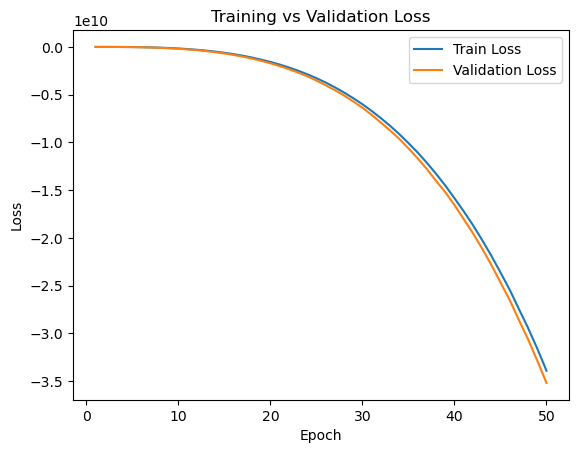

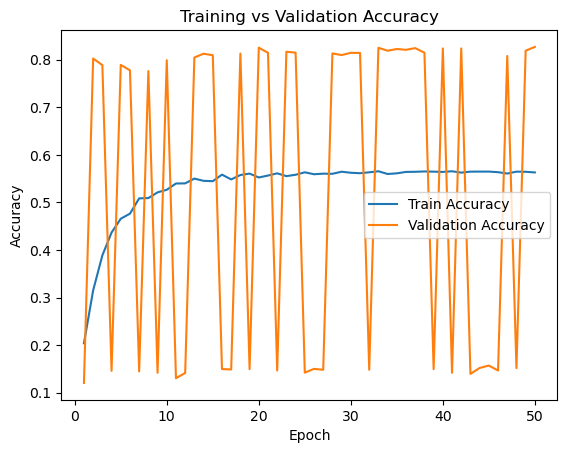

In [24]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_mse_history) + 1)

# -------- LOSS GRAPH --------
plt.figure()
plt.plot(epochs, train_mse_history)
plt.plot(epochs, val_mse_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(["Train Loss", "Validation Loss"])
plt.show()

# -------- ACCURACY GRAPH --------
plt.figure()
plt.plot(epochs, train_acc_history)
plt.plot(epochs, val_acc_history)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend(["Train Accuracy", "Validation Accuracy"])
plt.show()